In [1]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
train_path = "/kaggle/input/facebook-hateful-meme-dataset/data/train.jsonl"
val_path = "/kaggle/input/facebook-hateful-meme-dataset/data/dev.jsonl"
test_path = "/kaggle/input/df-test/df_test_seen.csv"
image_path = "/kaggle/input/facebook-hateful-meme-dataset/data/"

# train_path = "C:/Users/Ishit/Downloads/archive (1)/data/train.jsonl"
# val_path = "C:/Users/Ishit/Downloads/archive (1)/data/dev.jsonl"
# test_path = "C:/Users/Ishit/pytorch/DL_A4/data/df_test_seen.csv"
# image_path = "C:/Users/Ishit/Downloads/archive (1)/data/"


In [6]:
# Load the data
train_data = pd.read_json(train_path, lines=True)
val_data = pd.read_json(val_path, lines=True)
test_data = pd.read_csv(test_path)

In [7]:
len(train_data), len(val_data), len(test_data)

(8500, 500, 454)

In [8]:
train_data.head()

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [9]:
import matplotlib.pyplot as plt

def display_image(img_id):
    img_path = image_path + img_id
    return plt.imread(img_path)

0


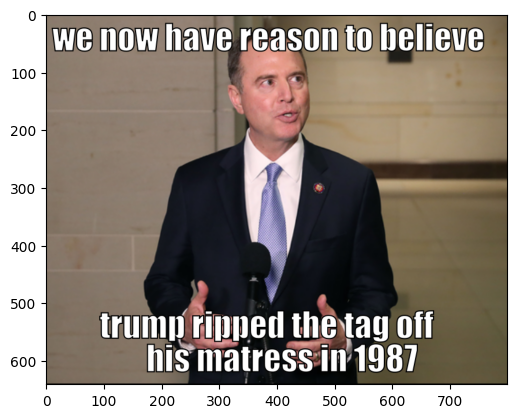

In [10]:
idx = 2000
img = display_image(train_data["img"][idx])
label = train_data["label"][idx]
plt.imshow(img)
print(label)

In [11]:
# take first 2500 rows and last 2500 rows and shuffle them
train_data = pd.concat([train_data[train_data['label'] == 0].head(2500), train_data[train_data['label'] == 1].head(2500)])
train_data['label'].value_counts()

label
0    2500
1    2500
Name: count, dtype: int64

In [12]:
# shuffle the data
train_data = train_data.sample(frac=1).reset_index(drop=True)
train_data.head()

,id,img,label,text
0,6794,img/06794.png,0,if you think the other puns where bad just wai...
1,78459,img/78459.png,1,you know like when the tv doesnt work you give...
2,43798,img/43798.png,0,when instagram notifies you that someone is go...
3,82016,img/82016.png,1,christians don't believe they evolved i agree
4,1487,img/01487.png,1,when you forget you're retarded


In [13]:
# plot class distribution
train_data["label"].value_counts()

label
0    2500
1    2500
Name: count, dtype: int64

In [14]:
# # drop the rows wth channels != 3
rows_to_drop = []

train_images = []
train_labels = []

for i in range(len(train_data)):
    img = display_image(train_data["img"][i])
    if img.shape[2] != 3:
        rows_to_drop.append(i)
    else:
        train_images.append(img)
        train_labels.append(train_data["label"][i])
        

In [15]:
rows_to_drop

[2489, 2758, 4774]

In [16]:
# rows_to_drop = [9, 327, 1753]
# train_data = train_data.drop(rows_to_drop, axis=0)
# train_data.reset_index(drop=True, inplace=True)
# train_data.head()

In [17]:
# train_images = []
# train_labels = []

# for i in range(5000):
#     img = display_image(train_data["img"][i])
#     train_images.append(img)
#     train_labels.append(train_data["label"][i])

In [18]:
len(train_images), len(train_labels)

(4997, 4997)

In [19]:
rows_to_drop = []

val_images = []
val_labels = []

for i in range(len(val_data)):
    img = display_image(val_data["img"][i])
    if img.shape[2] != 3:
        rows_to_drop.append(i)
    else:
        val_images.append(img)
        val_labels.append(val_data["label"][i])

In [20]:
len(val_images),len(val_labels)

(499, 499)

In [22]:
# same for test data
rows_to_drop = []

test_images = []
test_labels = []

for i in range(len(test_data)):
    img = display_image(test_data["img"][i])
    if img.shape[2] != 3:
        rows_to_drop.append(i)
    else:
        test_images.append(img)
        test_labels.append(test_data["label"][i])

In [23]:
class Image_Dataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

import torchvision.transforms as transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [24]:
train_dataset = Image_Dataset(train_images, train_labels, transform=transform)
val_dataset = Image_Dataset(val_images, val_labels, transform=transform)
test_dataset = Image_Dataset(test_images, test_labels, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_images), shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=len(test_images), shuffle=False)

In [25]:
for img, label in train_loader:
    print(img.shape, label.shape)
    break

torch.Size([256, 3, 224, 224]) torch.Size([256])


CNN

In [26]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 2)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64*28*28)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [31]:
# return the training and validation loss, accuracy f1 score, precision, recall
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    train_f1 = []
    val_f1 = []
    train_prec = []
    val_prec = []
    train_rec = []
    val_rec = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        y_true = []
        y_pred = []

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

            # --------- #
            # break
            # --------- #

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        acc = correct / total * 100

        f1, prec, rec = calculate_metrics(y_true, y_pred)

        train_acc.append(acc)
        train_f1.append(f1)
        train_prec.append(prec)
        train_rec.append(rec)
        
        print("-"*100)
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {acc:.2f}%, F1 Score: {f1:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")


        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        y_true = []
        y_pred = []

        with torch.no_grad():
            for i, data in enumerate(val_loader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

 

            val_loss = running_loss / len(val_loader)
            val_losses.append(val_loss)
            acc = correct / total * 100
            val_acc.append(acc)
            f1, prec, rec = calculate_metrics(y_true, y_pred)
            val_f1.append(f1)
            val_prec.append(prec)
            val_rec.append(rec)

            print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {acc:.2f}%, F1 Score: {f1:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")

        
    return train_losses, val_losses, train_acc, val_acc, train_f1, val_f1, train_prec, val_prec, train_rec, val_rec

def test_model(model, criterion, test_loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    y_true = []
    y_pred = []

    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

        test_loss = running_loss / len(test_loader)
        acc = correct / total * 100
        # classificaiton metrics report
        from sklearn.metrics import classification_report
        print(classification_report(y_true, y_pred))
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {acc:.2f}%")
        
        

# return f1 score, precision, recall
def calculate_metrics(true, pred):
    from sklearn.metrics import f1_score, precision_score, recall_score
    f1 = f1_score(true, pred)
    prec = precision_score(true, pred)
    rec = recall_score(true, pred)
    return f1, prec, rec

def plot_accuracies(train_acc, val_acc):
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

def plot_losses(train_loss, val_loss):
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [52]:
cnn = CNN()
cnn.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.0001, weight_decay=1e-3)

In [53]:
train_losses, val_losses, train_acc, val_acc, train_f1, val_f1, train_prec, val_prec, train_rec, val_rec = train_model(cnn, criterion, optimizer, train_loader, val_loader, num_epochs=10)

 -   -   -   -   -   -   -   -   -   -  
Epoch 1, Train Loss: 0.6936, Train Accuracy: 49.69%, F1 Score: 0.4396, Precision: 0.4965, Recall: 0.3944
Epoch 1, Validation Loss: 0.6933, Validation Accuracy: 49.30%, F1 Score: 0.0380, Precision: 0.3571, Recall: 0.0201
 -   -   -   -   -   -   -   -   -   -  
Epoch 2, Train Loss: 0.6927, Train Accuracy: 51.93%, F1 Score: 0.4229, Precision: 0.5295, Recall: 0.3520
Epoch 2, Validation Loss: 0.6940, Validation Accuracy: 49.50%, F1 Score: 0.6576, Precision: 0.4969, Recall: 0.9719
 -   -   -   -   -   -   -   -   -   -  
Epoch 3, Train Loss: 0.6924, Train Accuracy: 52.07%, F1 Score: 0.6347, Precision: 0.5129, Recall: 0.8324
Epoch 3, Validation Loss: 0.6934, Validation Accuracy: 48.70%, F1 Score: 0.1111, Precision: 0.4103, Recall: 0.0643
 -   -   -   -   -   -   -   -   -   -  
Epoch 4, Train Loss: 0.6923, Train Accuracy: 52.55%, F1 Score: 0.4014, Precision: 0.5441, Recall: 0.3180
Epoch 4, Validation Loss: 0.6938, Validation Accuracy: 49.90%, F1 Score

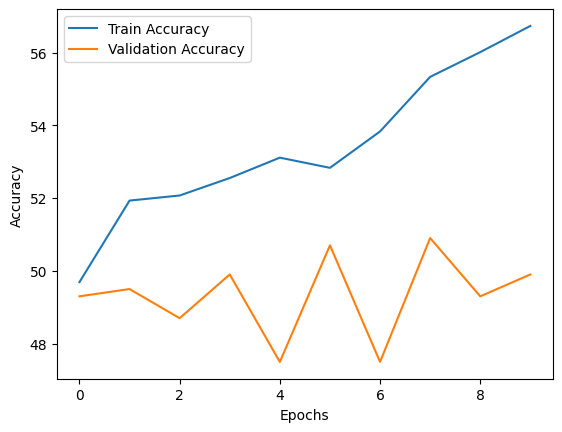

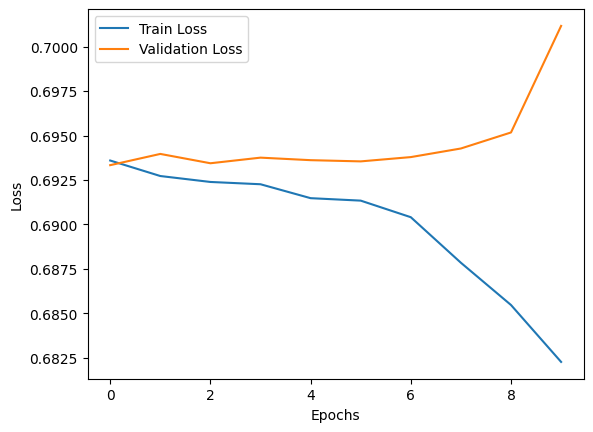

In [54]:
# plot accuracies
plot_accuracies(train_acc, val_acc)

# plot losses
plot_losses(train_losses, val_losses)

In [55]:
# test the model
test_model(cnn, criterion, test_loader)

              precision    recall  f1-score   support

           0       0.48      0.43      0.45       221
           1       0.51      0.56      0.53       233

    accuracy                           0.50       454
   macro avg       0.50      0.50      0.49       454
weighted avg       0.50      0.50      0.50       454

Test Loss: 0.6982, Test Accuracy: 49.78%


In [56]:
torch.save(cnn.state_dict(), "cnn.pth")

Resnet50

In [39]:
import torchvision.models as models
resnet = models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [40]:
# freeze the parameters
for param in resnet.parameters():
    param.requires_grad = False

# change the last layer
resnet.fc = nn.Linear(2048, 2)

In [41]:
# move the model to device
resnet.to(device)

# criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters(), lr=0.0005)

In [42]:
train_losses, val_losses, train_acc, val_acc, train_f1, val_f1, train_prec, val_prec, train_rec, val_rec = train_model(resnet, criterion, optimizer, train_loader, val_loader, num_epochs=10)

 -   -   -   -   -   -   -   -   -   -  
Epoch 1, Train Loss: 0.7076, Train Accuracy: 52.31%, F1 Score: 0.5381, Precision: 0.5220, Recall: 0.5552
Epoch 1, Validation Loss: 0.7123, Validation Accuracy: 49.50%, F1 Score: 0.2717, Precision: 0.4845, Recall: 0.1888
 -   -   -   -   -   -   -   -   -   -  
Epoch 2, Train Loss: 0.6858, Train Accuracy: 54.21%, F1 Score: 0.5417, Precision: 0.5425, Recall: 0.5408
Epoch 2, Validation Loss: 0.7061, Validation Accuracy: 50.90%, F1 Score: 0.3734, Precision: 0.5141, Recall: 0.2932
 -   -   -   -   -   -   -   -   -   -  
Epoch 3, Train Loss: 0.6726, Train Accuracy: 58.36%, F1 Score: 0.5790, Precision: 0.5858, Recall: 0.5724
Epoch 3, Validation Loss: 0.7047, Validation Accuracy: 51.10%, F1 Score: 0.5159, Precision: 0.5098, Recall: 0.5221
 -   -   -   -   -   -   -   -   -   -  
Epoch 4, Train Loss: 0.6680, Train Accuracy: 58.46%, F1 Score: 0.5884, Precision: 0.5833, Recall: 0.5936
Epoch 4, Validation Loss: 0.7100, Validation Accuracy: 50.10%, F1 Score

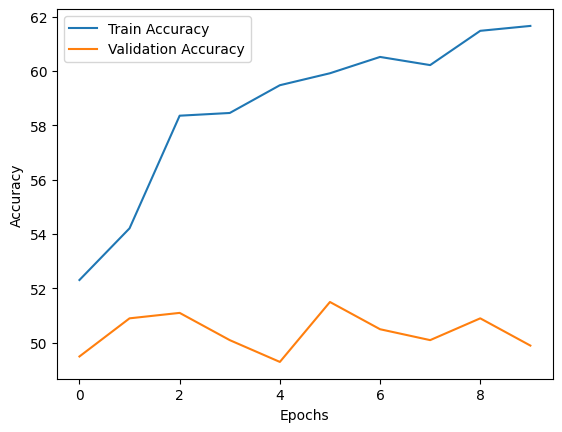

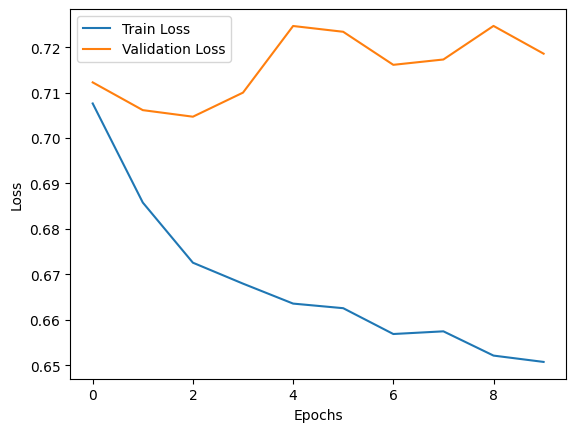

In [45]:
# plot accuracies
plot_accuracies(train_acc, val_acc)

# plot losses
plot_losses(train_losses, val_losses)

In [46]:
# test the model
test_model(resnet, criterion, test_loader)

              precision    recall  f1-score   support

           0       0.52      0.39      0.45       221
           1       0.53      0.66      0.59       233

    accuracy                           0.53       454
   macro avg       0.53      0.53      0.52       454
weighted avg       0.53      0.53      0.52       454

Test Loss: 0.7116, Test Accuracy: 52.86%


In [47]:
torch.save(resnet.state_dict(), "resnet.pth")